**Copyright**

Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük
az alábbi szerzőt értesíteni.

2021 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu),
Gyires-Tóth Bálint, Zainkó Csaba

Links:

hiperparaméter optimalizálás, hyperas: https://github.com/maxpumperla/hyperas

In [2]:
# a hyperas keretrendszer még tensorflow 1.x idején készült, de szerencsére működik 2.x-ben is
%tensorflow_version 2.x 

UsageError: Line magic function `%tensorflow_version` not found.


In [1]:
# érdemes előre telepíteni, és utána újraindítani
!pip3 install hyperas
!pip3 install hyperopt

You should consider upgrading via the 'c:\users\hajna\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\hajna\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
# először készítünk egy egyszerű hálót fashion_mnist osztályozásra

In [3]:
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
import numpy as np

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [5]:
batch_size = 32
num_classes = 10
epochs = 100

In [6]:
# one-hot enkódolttá alakítás
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [7]:
# átalakítás FC-DNN-hez & normalizálás, [0-1]
x_train = np.reshape(x_train,(-1,784)) / 255 # 28x28
x_test = np.reshape(x_test,(-1,784)) / 255

In [8]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=784))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, verbose=0)]

In [12]:
result = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              callbacks=callbacks,
              shuffle=True)

Epoch 1/100
1875/1875 [==============================] - 9s 4ms/step - loss: 0.7099 - accuracy: 0.7672 - val_loss: 0.5352 - val_accuracy: 0.8139
Epoch 2/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4809 - accuracy: 0.8352 - val_loss: 0.4726 - val_accuracy: 0.8333
Epoch 3/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4366 - accuracy: 0.8474 - val_loss: 0.4966 - val_accuracy: 0.8173
Epoch 4/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4097 - accuracy: 0.8567 - val_loss: 0.4627 - val_accuracy: 0.8373
Epoch 5/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3897 - accuracy: 0.8629 - val_loss: 0.4312 - val_accuracy: 0.8464
Epoch 6/100
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3736 - accuracy: 0.8686 - val_loss: 0.4011 - val_accuracy: 0.8580
Epoch 7/100
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3602 - accuracy: 0.8722 - val_loss: 0.3924 - val

In [13]:
# legnagyobb val_acc a háló tanításból
best_val_acc = np.amax(result.history['val_accuracy']) 
print('legjobb val_acc:', best_val_acc)

legjobb val_acc: 0.8701000213623047


In [14]:
# a következő részben alakítjuk át a hyperas számára megfelelő formátumba,
# amiben a fenti hálózatot egészítjük ki / alakítjuk át:
#  - adatok betöltése megy a data() függvénybe
#  - hálózat definíció, és utána choice-ok, 
#    valamint loggolás a create_model() függvényben
# 


In [15]:
# hyperas -> külön kell választani az adat betöltést és modell készítést

def data():
  (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
  
  num_classes = 10
  
  # one-hot enkódolttá alakítás
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  
  # átalakítás FC-DNN-hez & normalizálás, [0-1]
  x_train = np.reshape(x_train,(-1,784)) / 255 # 28x28
  x_test = np.reshape(x_test,(-1,784)) / 255
  
  return x_train, y_train, x_test, y_test

In [16]:
def create_model(x_train, y_train, x_test, y_test):
    
    # itt kezdődnek az általunk definiált hiperparaméterek,
    # amiket majd a modellbe teszünk bele
    n_layer1 = {{choice([128, 256, 512])}}
    n_layer2 = {{choice([128, 256, 512])}}
    dropout_1 = {{uniform(0, 0.5)}}
    dropout_2 = {{uniform(0, 0.5)}}
    act = {{choice(['relu', 'leakyrelu', 'swish'])}}
    optim = {{choice(['rmsprop', 'adam', 'sgd'])}}
    n_batch = {{choice([64, 128, 256])}}
    print('a modell hiperparaméterei: ', n_layer1, n_layer2, dropout_1, dropout_2, act, optim, n_batch)
    # 3 x 3 x [0-1]x[0-1] x 3 x 3 x 3  = hatalmas paraméter tér
    
    model = Sequential()
    model.add(Dense(n_layer1, activation=act, input_dim=784))
    model.add(Dropout(dropout_1))
    model.add(Dense(n_layer2, activation=act))
    model.add(Dropout(dropout_2))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer=optim,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, verbose=0)]
    
    result = model.fit(x_train, y_train,
              batch_size=n_batch,
              epochs=100,
              verbose=2,
              validation_data=(x_test, y_test),
              callbacks=callbacks,
              shuffle=True)

    
    # az epoch-ok közül a legnagyobb val_acc elmentése
    best_val_acc = np.amax(result.history['val_accuracy']) 
    print('legjobb val_acc:', best_val_acc)
    
    # log kiírása: háló struktúra, és az eredmény
    with open('hyperas-fashionmnist-log.csv', 'a') as csv_file:
      csv_file.write(str(n_layer1) + ';')
      csv_file.write(str(n_layer2) + ';')
      csv_file.write(str(dropout_1) + ';')
      csv_file.write(str(dropout_2) + ';')
      csv_file.write(str(act) + ';')
      csv_file.write(str(optim) + ';')
      csv_file.write(str(n_batch) + ';')
      csv_file.write(str(best_val_acc) + '\n')


    # negatív val_acc, mert a hyperopt csomag mindig minimalizál
    return {'loss': -best_val_acc, 'status': STATUS_OK, 'model': model}

In [17]:

# log fájl inicializálás / fejléc
with open('hyperas-fashionmnist-log.csv', 'w') as csv_file:
  csv_file.write('n_layer1' + ';')
  csv_file.write('n_layer2' + ';')
  csv_file.write('dropout_1' + ';')
  csv_file.write('dropout_2' + ';')
  csv_file.write('act' + ';')
  csv_file.write('optim' + ';')
  csv_file.write('n_batch' + ';')
  csv_file.write('best_val_acc' + '\n')


In [18]:
# ezután colab-ról le kell tölteni a notebook-ot
# és a .ipynb fájlt utána visszatölteni az aktuális könyvtárba

# erre azért van szükség, mert a hyperas a fenti kódben regexp-ekkel cseréli ki
# a hiperparaméter változókat az adott értékekre

# ha nem jupyter notebook-ban használjuk a hyperas-t, akkor nem kell ilyen trükközés

In [19]:
# hyperas-hoz kapcsolódó importok
import hyperas
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [20]:
# teljes hiperparaméter optimalizálás indítása
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          notebook_name='hyperas_fashionmnist',
                                          trials=Trials())

UnicodeDecodeError: 'charmap' codec can't decode byte 0x88 in position 46961: character maps to <undefined>

In [ ]:
x_train, y_train, x_test, y_test = data()
print("legjobb modell kiértékelése:")
print(best_model.evaluate(x_test, y_test))
print("legjobb hiperparaméterek:")
# a best_run az indexeket adja vissza,
# azaz pl: 
# n_layer1 = {{choice([128, 256, 512])}}
# és 
# 'n_layer1': 1
# -> a legjobb n_layer1 érték a 256
print(best_run)

legjobb modell kiértékelése:
313/313 [==============================] - 1s 4ms/step - loss: 0.3399 - accuracy: 0.8891
[0.33986896276474, 0.8891000151634216]
legjobb hiperparaméterek:
{'act': 0, 'dropout_1': 0.19749681333133445, 'dropout_1_1': 0.48790925917284717, 'n_batch': 0, 'n_layer1': 2, 'n_layer1_1': 2, 'optim': 1}


In [ ]:
# ugyan 5 futtatás nagyon kevés,
# de sikerült jobb eredményt elérni, mint a fenti egyszerű hálózattal
# (88.91% vs. 88.04%)

In [21]:
import pandas
df = pandas.read_csv('hyperas-fashionmnist-log_829.csv', delimiter=';')
df.sort_values(by=['best_val_acc'], ascending=False)

,n_layer1,n_layer2,dropout_1,dropout_2,act,optim,n_batch,best_val_acc
613,256,256,0.057500,0.236159,relu,adam,128,0.9021
703,256,256,0.055486,0.219630,relu,adam,128,0.8999
599,256,256,0.093041,0.187372,relu,adam,128,0.8989
590,256,256,0.186405,0.155035,relu,adam,128,0.8986
520,256,256,0.219907,0.137933,relu,adam,256,0.8984
...,...,...,...,...,...,...,...,...
103,256,256,0.330860,0.032585,swish,sgd,256,0.8353
209,128,256,0.416123,0.497800,swish,sgd,128,0.8352
675,256,256,0.093233,0.231088,swish,sgd,128,0.8350
0,128,256,0.305438,0.368585,swish,sgd,256,0.8310


In [ ]:
# a valóságban inkább ~1000 futtatás érdemes
# -> itt most megvizsgáljuk egy korábbi hiperopt eredményét
# feltöltendő: hyperas-fashionmnist-log_829.csv

In [ ]:
# a következő részben betöltjük a nagy csv fájlt (~1000 tanítás eredménye), majd
# adat vizualizáció, azaz hogyan függ a val_acc a háló egyes paramétereitől?

In [22]:
import pandas
hyperas_log = pandas.read_csv('hyperas-fashionmnist-log_829.csv', delimiter=';')

In [23]:
# nézzük meg a 10 legjobb hálót!
hyperas_best10 = hyperas_log.sort_values(by=['best_val_acc'], ascending=False).head(n=10)
hyperas_best10

,n_layer1,n_layer2,dropout_1,dropout_2,act,optim,n_batch,best_val_acc
613,256,256,0.057500,0.236159,relu,adam,128,0.9021
703,256,256,0.055486,0.219630,relu,adam,128,0.8999
599,256,256,0.093041,0.187372,relu,adam,128,0.8989
590,256,256,0.186405,0.155035,relu,adam,128,0.8986
520,256,256,0.219907,0.137933,relu,adam,256,0.8984
820,256,256,0.074415,0.124319,relu,adam,128,0.8982
793,256,256,0.027088,0.163121,relu,adam,128,0.8982
192,512,256,0.055206,0.118134,relu,rmsprop,256,0.8982
539,256,256,0.161702,0.241673,relu,adam,128,0.8981
688,256,256,0.068579,0.238220,relu,adam,128,0.8980


In [24]:
# és nézzük meg a 10 legrosszabb hálót is!
hyperas_worst10 = hyperas_log.sort_values(by=['best_val_acc'], ascending=False).tail(n=10)
hyperas_worst10

,n_layer1,n_layer2,dropout_1,dropout_2,act,optim,n_batch,best_val_acc
645,256,512,0.079881,0.218893,swish,sgd,128,0.8374
174,256,128,0.413120,0.138235,swish,sgd,128,0.8373
110,128,256,0.487781,0.181827,swish,sgd,64,0.8370
188,256,128,0.317484,0.481827,swish,sgd,128,0.8369
75,128,256,0.261419,0.020091,swish,sgd,64,0.8364
103,256,256,0.330860,0.032585,swish,sgd,256,0.8353
209,128,256,0.416123,0.497800,swish,sgd,128,0.8352
675,256,256,0.093233,0.231088,swish,sgd,128,0.8350
0,128,256,0.305438,0.368585,swish,sgd,256,0.8310
86,128,256,0.420083,0.027004,swish,sgd,256,0.8303


In [25]:
# de vajon hogy függnek össze az egyes hiperparaméterek a val_acc-cal?
import matplotlib.pyplot as plt

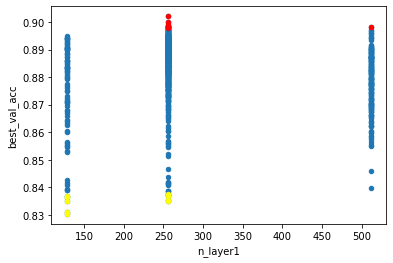

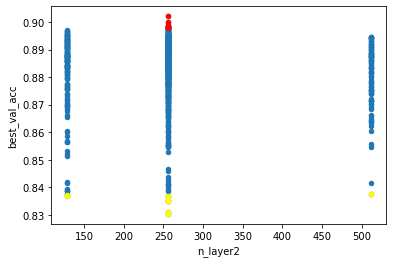

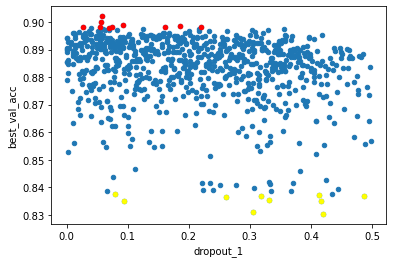

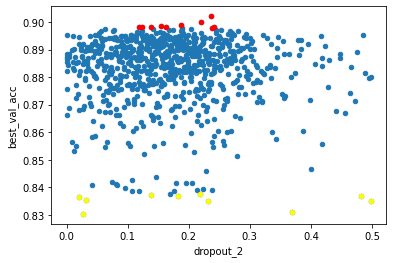

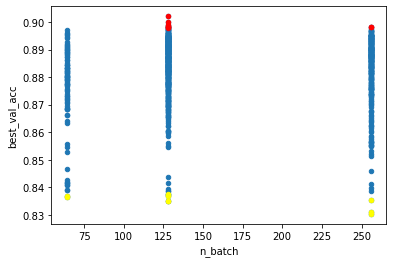

In [26]:
# összes adat kékkel,
# legjobb 10 hálózat pirossal
for hyperparam in ['n_layer1', 'n_layer2', 'dropout_1', 'dropout_2', 'n_batch']:
  ax1 = hyperas_log.plot(kind='scatter', x=hyperparam, y='best_val_acc')
  hyperas_best10.plot(kind='scatter', x=hyperparam, y='best_val_acc', color='red', ax=ax1)
  hyperas_worst10.plot(kind='scatter', x=hyperparam, y='best_val_acc', color='yellow', ax=ax1)

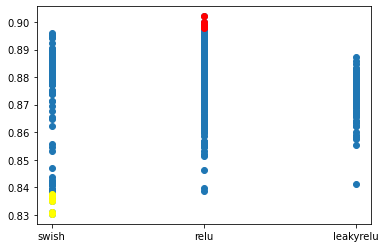

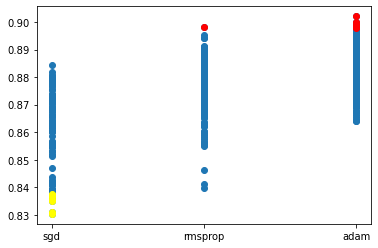

In [27]:
# act, optim: kategorikus változók
# (https://github.com/pandas-dev/pandas/issues/18755)
plt.scatter(hyperas_log.act, hyperas_log.best_val_acc)
plt.scatter(hyperas_best10.act, hyperas_best10.best_val_acc, color='red')
plt.scatter(hyperas_worst10.act, hyperas_worst10.best_val_acc, color='yellow')
plt.show()

plt.scatter(hyperas_log.optim, hyperas_log.best_val_acc)
plt.scatter(hyperas_best10.optim, hyperas_best10.best_val_acc, color='red')
plt.scatter(hyperas_worst10.optim, hyperas_worst10.best_val_acc, color='yellow')
plt.show()


In [28]:
# de vajon hogy függ össze az egyes hiperparaméterek kombinációja a val_acc-cal?
# ábrázoljuk seaborn-nal

import seaborn as sns


(3.5, -0.5)

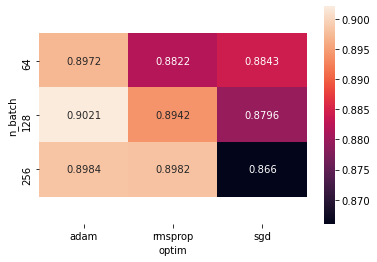

In [29]:
max_val_acc = hyperas_log.groupby(['n_batch', 'optim']).max()
max_val_acc = max_val_acc.unstack()[['best_val_acc']]
sns.heatmap(max_val_acc.best_val_acc, annot=True, fmt='.4g');

# bug: seaborn cuts off borders, https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

In [30]:
# de vajon hogy függ össze az egyes hiperparaméterek kombinációja a val_acc-cal?
# ábrázoljuk matplotlib / scatter3d-vel

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D

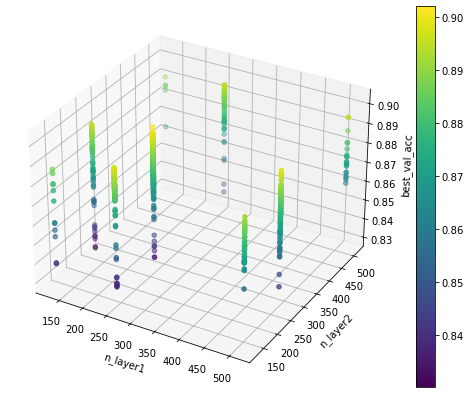

In [31]:
# n_layer1 / n_layer2
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(hyperas_log.n_layer1, hyperas_log.n_layer2, hyperas_log.best_val_acc, c=hyperas_log.best_val_acc)
ax.set_xlabel('n_layer1')
ax.set_ylabel('n_layer2')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

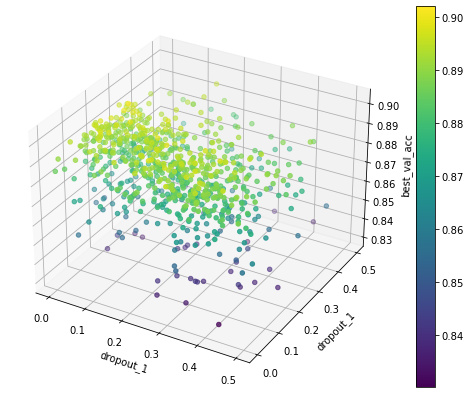

In [32]:
# dropout_1 / dropout_2
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(hyperas_log.dropout_1, hyperas_log.dropout_2, hyperas_log.best_val_acc, c=hyperas_log.best_val_acc)
ax.set_xlabel('dropout_1')
ax.set_ylabel('dropout_1')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

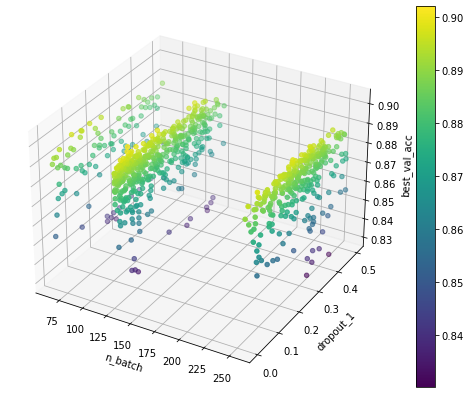

In [33]:
# n_batch / dropout_1
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(hyperas_log.n_batch, hyperas_log.dropout_1, hyperas_log.best_val_acc, c=hyperas_log.best_val_acc)
ax.set_xlabel('n_batch')
ax.set_ylabel('dropout_1')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

In [34]:
# a fenti logok és ábrák alapján úgy tűnik, hogy a nyerő kombináció:
# - n_layer1=256, n_layer2=256
# - dropout alacsony
# - act=relu
# - optim=adam
# - n_batch=128

In [35]:
# VÉGE.
# konklúzió: hyperas-szal kb 5-10%-nyi pontosságot sikerült nyerni
# de: nagyobb háló / komplexebb probléma esetén lényegesen többet is lehet javítani
